In [2]:
import re
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
from sklearn import metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [3]:
df_train = pd.read_csv('train.tsv', sep='\t')
df_test = pd.read_csv('test.tsv', sep='\t')
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
#this should help you to decide whether to use STOP WORDS or not.
#This part of code is just great analytical tool

# 停顿词
stop_word = set(stopwords.words('english')) 

# 词向量
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word', min_df=0.001)

# 稀疏矩阵
sparse_matrix = word_vectorizer.fit_transform(df_test['Phrase'])
frequencies = sum(sparse_matrix).toarray()[0]
freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
freq.sort_values('frequency', ascending=False)

,frequency
the,20181
and,12594
of,12508
to,9142
in,5658
...,...
told,67
sports,67
brilliant,67
change,67


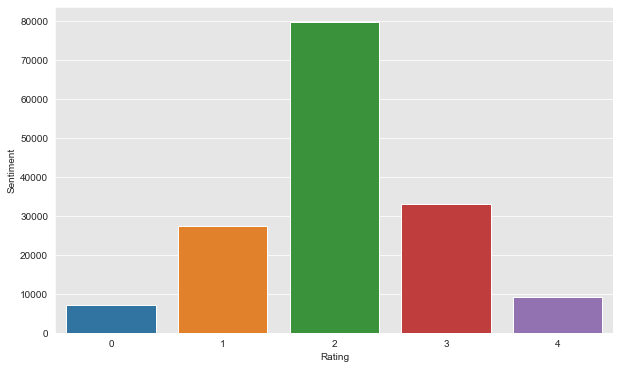

In [5]:
#Visualization of data set
a = df_train.Sentiment.value_counts()
a = pd.DataFrame(a)
a['Rating'] = a.index
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y='Sentiment', x='Rating', data=a)

In [6]:
#we make text lower case and leave only letters from a-z and digits
df_train['Phrase'] = df_train['Phrase'].str.lower()
df_train['Phrase'] = df_train['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df_test['Phrase'] = df_test['Phrase'].str.lower()
df_test['Phrase'] = df_test['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [7]:
X_train = df_train.Phrase
y_train = df_train.Sentiment
tokenize = Tokenizer()
tokenize.fit_on_texts(X_train.values)

In [8]:
X_test = df_test.Phrase
X_train = tokenize.texts_to_sequences(X_train)
X_test = tokenize.texts_to_sequences(X_test)

In [9]:
max_lenght = max([len(s.split()) for s in df_train['Phrase']])
X_train = pad_sequences(X_train, max_lenght)
X_test = pad_sequences(X_test, max_lenght)
print(X_train.shape)
print(X_test.shape)

(156060, 48)
(66292, 48)


# 模型建立

In [2]:
#choose to build 4 hidden layers
EMBEDDING_DIM = 100
unknown = len(tokenize.word_index)+1
model = Sequential()
model.add(Embedding(unknown, EMBEDDING_DIM, input_length=max_lenght))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
# model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True ))
# model.add(LSTM(units=64,dropout=0.2, recurrent_dropout=0.2,return_sequences=False))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: name 'tokenize' is not defined

In [11]:
print(model.summary())
print(y_train.shape)
print(X_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 100)           1637800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 1,755,693
Trainable params: 1,755,693
Non-trainable params: 0
_________________________________________________________________
None
(156060,)
(156060, 48)


In [ ]:
# 训练模型
model.fit(X_train, y_train, batch_size=256, epochs=3, verbose=1)

In [ ]:
final_pred = model.predict_classes(X_test)
final_pred[:3]

In [1]:
#Additionally before I took deep learning technique, I tested Naive Bayes, 
#Random Forest and SVM approach to test which model works better.
#RF showed the best results for test data 0.62.
#Code below
#As well I tried to use 
df_train = pd.read_csv('../input/train.tsv', sep='\t')
df_train['Phrase'] = df_train['Phrase'].str.lower()
stop_word = set(stopwords.words('english')) 
#df_train['Phrase_no_stopwords'] = df_train['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))
df_train['tokezines_sents'] = df_train.apply(lambda x: nltk.word_tokenize(x['Phrase']),axis=1)
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
df_train['tokezines_sents'] = df_train['tokezines_sents'].apply(lambda x: [stemmer.stem(y) for y in x])
df_train['tokezines_sents'] = df_train['tokezines_sents'].apply(lambda x: ' '.join(x))
from sklearn.model_selection import train_test_split
x=df_train.tokezines_sents
y=df_train.Sentiment
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,  random_state=1)
x_train_df = vect.fit_transform(X_train)
x_test_df = vect.transform(X_test)
print('Number of features:', len(vect.get_feature_names()))
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_df, y_train)
y_pred_class = nb.predict(x_test_df)
print('NB:', metrics.accuracy_score(y_test, y_pred_class))
from sklearn.linear_model import SGDClassifier
SVM = SGDClassifier()
SVM.fit(x_train_df, y_train)
y_pred_class = SVM.predict(x_test_df)
print('SVM:', metrics.accuracy_score(y_test, y_pred_class))

https://www.kaggle.com/stass30/result-0-66-lstm-vs-machine-learning